In [41]:
import sys
sys.path.append('A:\MSBGD\Data_Challenge')
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from source.evaluator import gap_eval_scores
from source.preprocessing import pca_norm,balance_data

with open('../data/data-challenge-student.pickle', 'rb') as handle:
    # dat = pickle.load(handle)
    dat = pd.read_pickle(handle)

In [42]:
X = dat['X_train']
Y = dat['Y']
S = dat['S_train']

In [43]:
X.shape

(27749, 768)

In [44]:
X_res, Y_res, S_res = balance_data(X, Y, S)
X_pca, pca = pca_norm(X_res, n_components=0.95)

# save preprocessed data
#with open('../data/preprocessed_data.pickle', 'wb') as handle:
#    pickle.dump({'X': X_pca, 'Y': Y_res, 'S': S_res}, handle, protocol=pickle.HIGHEST_PROTOCOL)
#    print('Preprocessed data saved')


In [ ]:
print(X_pca.shape)

(231980, 284)


In [ ]:
# number of classes
print("Y unique :",Y_res.unique().shape[0])
print("Y value counts :",Y_res.value_counts())

Y unique : 28
Y value counts : profession_class
6     8285
9     8285
22    8285
21    8285
19    8285
18    8285
13    8285
2     8285
1     8285
26    8285
12    8285
11    8285
25    8285
15    8285
20    8285
7     8285
27    8285
5     8285
14    8285
24    8285
3     8285
4     8285
23    8285
0     8285
16    8285
17    8285
8     8285
10    8285
Name: count, dtype: int64


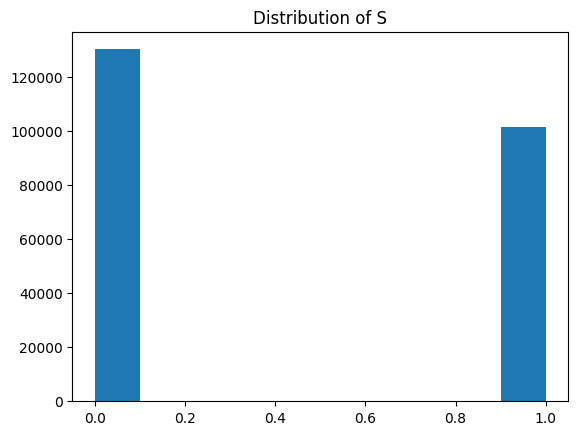

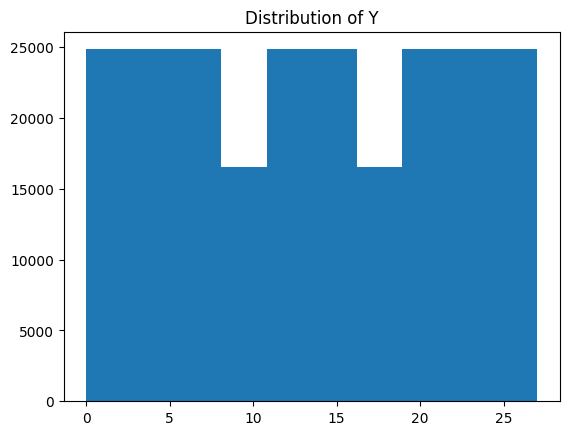

In [ ]:
# visualize distribution of data
plt.hist(S_res)
plt.title('Distribution of S')
plt.show()

# visualize distribution of data
plt.hist(Y_res)
plt.title('Distribution of Y')
plt.show()

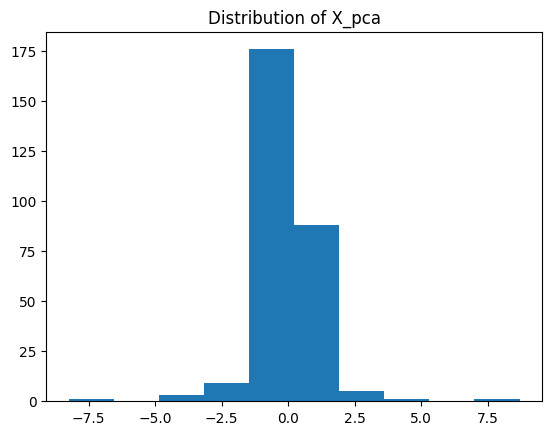

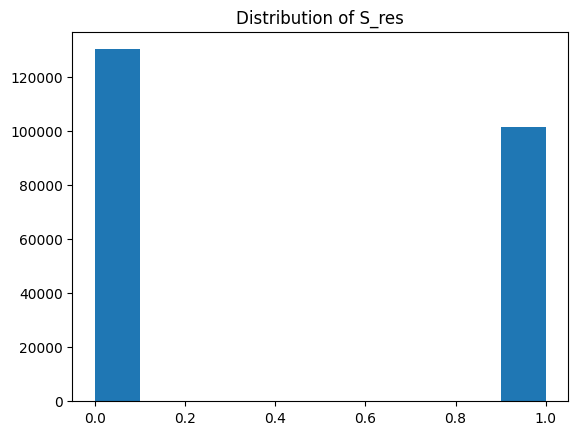

In [ ]:
plt.hist(X_pca[0,:])
plt.title('Distribution of X_pca')
plt.show()

plt.hist(S_res)
plt.title('Distribution of S_res')
plt.show()


In [ ]:
# # Feature selection with pca
# pca = PCA()
# pca.fit(X_res)
# # cumulative explained variance
# cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()
# plt.plot(cumulative_explained_variance)
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# plt.title('cumulative explained variance as a function of the number of components')
# plt.show()

In [10]:

# split data into train and test
X_train, X_test, Y_train, Y_test, S_train, S_test = train_test_split(X_pca, Y_res, S_res, test_size=0.3, random_state=42)
# convert all to numpy array
Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
Y_train = torch.from_numpy(Y_train)
Y_test = torch.from_numpy(Y_test)

In [40]:
print("X_train shape :",X_train.shape)
print("X_test shape :",X_test.shape)
print("Y_train shape :",Y_train.shape)
print("Y_test shape :",Y_test.shape)

X_train shape : torch.Size([162386, 284])
X_test shape : torch.Size([11893, 284])
Y_train shape : torch.Size([162386])
Y_test shape : torch.Size([69594])


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.MLP = nn.Sequential(
            nn.Linear(284, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 28),
            nn.Softmax()
        )

    def forward(self, x):
        logits = self.MLP(x)
        return logits

loss_fn = nn.CrossEntropyLoss()

# Create an instance of the neural network
model = NeuralNetwork().to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Training loop
def train(model, optimizer, loss_fn, inputs, labels, n_epochs):
    model.train()
    # using dataset cla
    inputs = inputs.to(device)
    labels = labels.to(device)

    for epoch in range(n_epochs):
        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Example usage
inputs = X_train.to(device)
labels = Y_train.to(device)
n_epochs = 3300
train(model, optimizer, loss_fn, inputs, labels, n_epochs)


Epoch 0, Loss: 3.3321940898895264
Epoch 1, Loss: 3.327871084213257
Epoch 2, Loss: 3.313887119293213
Epoch 3, Loss: 3.268853187561035
Epoch 4, Loss: 3.1989898681640625
Epoch 5, Loss: 3.1227471828460693
Epoch 6, Loss: 3.0675015449523926
Epoch 7, Loss: 3.010721206665039
Epoch 8, Loss: 2.9676427841186523
Epoch 9, Loss: 2.9192616939544678
Epoch 10, Loss: 2.8870508670806885
Epoch 11, Loss: 2.8453469276428223
Epoch 12, Loss: 2.813666820526123
Epoch 13, Loss: 2.7796969413757324
Epoch 14, Loss: 2.7502634525299072
Epoch 15, Loss: 2.7245090007781982
Epoch 16, Loss: 2.6952126026153564
Epoch 17, Loss: 2.672865390777588
Epoch 18, Loss: 2.6514413356781006
Epoch 19, Loss: 2.6377065181732178
Epoch 20, Loss: 2.6287877559661865
Epoch 21, Loss: 2.6130547523498535
Epoch 22, Loss: 2.6042745113372803
Epoch 23, Loss: 2.5959253311157227
Epoch 24, Loss: 2.5889270305633545
Epoch 25, Loss: 2.5833017826080322
Epoch 26, Loss: 2.578640937805176
Epoch 27, Loss: 2.5740487575531006
Epoch 28, Loss: 2.5691168308258057
Ep

In [ ]:
from source.dataset import ChallengeDataset
from torch.utils.data import DataLoader, random_split

data_path = '../data/preprocessed_data.pickle'
dataset = ChallengeDataset(X_train, Y_train)
dataset = ChallengeDataset(
    data_path=data_path)
total_length = len(dataset)  # Total number of samples in the dataset
# Define the proportions of the splits
train_size = int(0.7 * total_length)  # 70% of the dataset for training
valid_size = int(0.2 * total_length)  # 20% for validation
# The rest for testing, to ensure no sample is left out
test_size = total_length - train_size - valid_size
# Perform the split
train_dataset, valid_dataset, test_dataset = random_split(
    dataset, [train_size, valid_size, test_size])



def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()  # Set the model to training mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)  # Move data to the appropriate device

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()  # Reset the gradients in the optimizer
        loss.backward()  # Compute the gradients
        optimizer.step()  # Update the model parameters

        if batch % 100 == 0:  # Print loss every 100 batches
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(dataloader.dataset):>5d}]")

# Example usage
n_epochs = 5  # Number of epochs

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    print("-------------------------------")

In [37]:
# Test the model
def evaluate(model, inputs, labels):
    model.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(inputs)
    _, Y_pred = torch.max(outputs, 1)
    Y_pred = Y_pred.cpu().numpy()
    # Compute the accuracy
    eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, S_test, metrics=['TPR'])
    final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2
    print(final_score)
    return eval_scores, confusion_matrices_eval

inputs = X_test.to(device)
labels = Y_test.to(device)
evaluate(model, inputs, labels)

ValueError: Found input variables with inconsistent numbers of samples: [69594, 11893]

In [15]:
# Load the "true" test data
X_test = dat['X_test']
S_test = dat['S_test'] 
# Classify the provided test data with you classifier
X_test = pca.transform(X_test)

X_test = torch.tensor(X_test)
inputs = X_test.to(device)
outputs = model(inputs)
_, y_test = torch.max(outputs, 1)
y_test = y_test.cpu().numpy()
results=pd.DataFrame(y_test, columns= ['score'])

results.to_csv("Data_Challenge_MDI_341.csv", header = None, index = None)
# np.savetxt('y_test_challenge_student.txt', y_test, delimiter=',')

/home/aleksander/.local/share/virtualenvs/Data_Challenge-2KO3xTh2/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/aleksander/.local/share/virtualenvs/Data_Challenge-2KO3xTh2/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
